In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.pipeline import make_pipeline
import os

# skimage
import skimage
import skimage.color
import skimage.transform
import skimage.feature
import skimage.io

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

class rgb2gray_transform(BaseEstimator,TransformerMixin):
    import skimage.color
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return np.array([skimage.color.rgb2gray(x) for x in X])
    
    
class hogtransformer(BaseEstimator,TransformerMixin):
    import skimage.feature
    def __init__(self,orientations=9,pixels_per_cell=(8, 8),cells_per_block=(3, 3),):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        def local_hog(img):
            hog_features= skimage.feature.hog(img,orientations=self.orientations,
                                pixels_per_cell=self.pixels_per_cell,
                                cells_per_block=self.cells_per_block)
            
            return hog_features
        
        hfeatures = np.array([local_hog(x) for x in X])
        return hfeatures

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
ls images


 Volume in drive D is DATA
 Volume Serial Number is FAA9-24C8

 Directory of D:\Image classifier\images

26-05-2021  09:36    <DIR>          .
26-05-2021  09:36    <DIR>          ..
21-02-2021  18:51            35,167 astro_gray.jpg
21-02-2021  16:01            40,344 astronaut.jpg
21-02-2021  16:02            41,686 coffee.jpg
21-02-2021  16:03             8,344 colorwheel.jpg
07-02-2021  14:15            51,426 dog_test.jpg
07-02-2021  14:08            98,479 eagle.jpg
21-02-2021  19:07             3,428 landscape.jpg
21-02-2021  19:17             8,844 landscape_hist_eq.jpg
02-02-2021  21:41           122,337 lion.bmp
21-02-2021  16:01            28,644 rocket.jpg
              10 File(s)        438,699 bytes
               2 Dir(s)  285,662,416,896 bytes free


In [7]:
# pipeline model
image = skimage.io.imread('./images/eagle.jpg')
# transform image into 80 x 80
image_resize = skimage.transform.resize(image,(80,80))
image_scale = 255*image_resize
image_transform = image_scale.astype(np.uint8)
# rgb to gray
gray = skimage.color.rgb2gray(image_transform)
# hog feature
feature_vector = skimage.feature.hog(gray,
                              orientations=10,
                              pixels_per_cell=(8,8),cells_per_block=(2,2))

In [8]:
feature_vector

array([0.20892749, 0.02576187, 0.25915192, ..., 0.04869078, 0.03815464,
       0.00625194])

In [9]:
import pickle
# load the model
model = pickle.load(open('dsa_image_classification_sgd.pickle','rb'))
scaler = pickle.load(open('dsa_scaler.pickle','rb'))

In [10]:
feature_vector.shape

(3240,)

In [11]:
scalex = scaler.transform(feature_vector.reshape(1,-1))
result = model.predict(scalex)

In [12]:
result

array(['duck'], dtype='<U8')

In [13]:
# cal the probabilty 
decision_value = model.decision_function(scalex)

In [14]:
decision_value

array([[-216.49925255, -185.69529581, -114.69686706, -181.75468272,
        -240.40850663, -207.13547892,  -18.06080401,  -22.47293939,
        -274.52952702, -160.062546  , -253.2659755 ,  -25.31498835,
        -252.2442792 , -211.07916947,  -72.90795904,  -46.64320313,
        -170.02816202, -179.6618018 , -153.61495354, -354.29498318]])

In [15]:
labels = model.classes_

In [16]:
decision_value = decision_value.flatten()

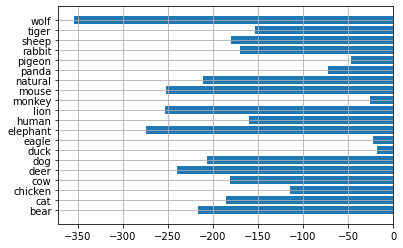

In [17]:
plt.barh(labels,decision_value)
plt.grid()

In [18]:
# cal. z score
z = scipy.stats.zscore(decision_value)
prob_value = scipy.special.softmax(z)
prob_value

array([0.01772299, 0.02493203, 0.05474994, 0.02604467, 0.01359853,
       0.01966044, 0.15972438, 0.15210418, 0.00931774, 0.03312042,
       0.01179302, 0.1473893 , 0.01192728, 0.01881989, 0.08698833,
       0.11636976, 0.02965814, 0.02665565, 0.03557296, 0.00385035])

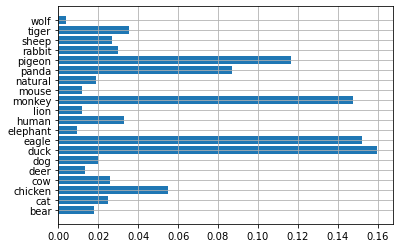

In [19]:
plt.barh(labels,prob_value)
plt.grid()

In [20]:
# top five probabilty values
top_5_prob_ind = prob_value.argsort()[::-1][:5]

In [21]:
top_5_prob_ind

array([ 6,  7, 11, 15, 14], dtype=int64)

In [22]:
top_labels = labels[top_5_prob_ind]
top_prob = prob_value[top_5_prob_ind]

In [23]:
top_prob,top_labels

(array([0.15972438, 0.15210418, 0.1473893 , 0.11636976, 0.08698833]),
 array(['duck', 'eagle', 'monkey', 'pigeon', 'panda'], dtype='<U8'))

In [26]:
top_dict = dict()
for key,val in zip(top_labels,top_prob):
    top_dict.update({key:np.round(val,4)})

In [27]:
top_dict

{'duck': 0.1597,
 'eagle': 0.1521,
 'monkey': 0.1474,
 'pigeon': 0.1164,
 'panda': 0.087}

In [30]:
def pipeline_model(path,scaler_transform,model_sgd):
    # pipeline model
    image = skimage.io.imread(path)
    # transform image into 80 x 80
    image_resize = skimage.transform.resize(image,(80,80))
    image_scale = 255*image_resize
    image_transform = image_scale.astype(np.uint8)
    # rgb to gray
    gray = skimage.color.rgb2gray(image_transform)
    # hog feature
    feature_vector = skimage.feature.hog(gray,
                                  orientations=10,
                                  pixels_per_cell=(8,8),cells_per_block=(2,2))
    # scaling
    
    scalex = scaler_transform.transform(feature_vector.reshape(1,-1))
    result = model_sgd.predict(scalex)
    # decision function # confidence
    decision_value = model_sgd.decision_function(scalex).flatten()
    labels = model_sgd.classes_
    # probability
    z = scipy.stats.zscore(decision_value)
    prob_value = scipy.special.softmax(z)
    
    # top 5
    top_5_prob_ind = prob_value.argsort()[::-1][:5]
    top_labels = labels[top_5_prob_ind]
    top_prob = prob_value[top_5_prob_ind]
    # put in dictornary
    top_dict = dict()
    for key,val in zip(top_labels,top_prob):
        top_dict.update({key:np.round(val,4)})
    
    return top_dict

In [31]:
res = pipeline_model('./images/eagle.jpg',scaler,model)
res

{'duck': 0.1597,
 'eagle': 0.1521,
 'monkey': 0.1474,
 'pigeon': 0.1164,
 'panda': 0.087}